In [10]:
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
eps = np.finfo(float).eps
from numpy import log2 as log

df =pd.read_csv('/home/neelesh/Downloads/train.csv')
df = df[['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company','Work_accident','promotion_last_5years','salary','sales','left']]
df.salary.replace(('low', 'medium','high'), (0,1,2), inplace=True)
df.sales.replace(('sales', 'accounting','technical','management','IT','product_mng','hr','marketing','RandD','support'), (0,1,2,3,4,5,6,7,8,9), inplace=True)
X =df[['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company','Work_accident','promotion_last_5years','salary','sales']]
Y = df[['left']] 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)
df=pd.concat([X_train,Y_train], axis=1)


In [11]:
def find_entropy(df):
    entropy_node = 0 
    values = df.left.unique() 
    for value in values:
        fraction = df.left.value_counts()[value]*1.0/len(df.left) 
        if(fraction!=0):
            entropy_node += -fraction*np.log2(fraction) 
    return entropy_node

In [12]:
def find_entropy_attribute(df,attribute):
    target_variables = df.left.unique()
    
    df1=df.sort_values(attribute)
    arr=np.array(df1[attribute].unique())
    if(len(arr)==1):
        return arr[0],999
    arr1=np.array(df1[attribute])
    arr2=np.array(df1['left'])
    minentropy=None
    ans=None
    for i in range(0,len(arr)-1):
            val=(arr[i]+arr[i+1])/2.0
            left_zero=0
            right_zero=0
            left_one=0
            right_one=0

            for j in range(0,len(df)):
                if(arr1[j]<=val):
                    if(arr2[j]==0):
                        left_zero+=1
                    else:
                        left_one+=1
                else:
                    if(arr2[j]==0):
                        right_zero+=1
                    else:
                        right_one+=1

            fraction1=float(left_zero)/(left_zero+left_one+eps)
            E=(fraction1*np.log2(fraction1+eps))            
            E+=(1-fraction1)*np.log2(1-fraction1+eps)
            E*=-1        
            fraction2=float(left_zero+left_one)/len(df1)
            I=fraction2*E
    

            fraction1=float(right_zero)/(right_zero+right_one+eps)
            E=(fraction1*np.log2(fraction1+eps))      
            E+=((1-fraction1)*np.log2(1-fraction1+eps))
            E*=-1           
            fraction2=float(right_zero+right_one)/len(df1)
            I+=fraction2*E

            if(minentropy is None or I<minentropy):
                minentropy=I
                ans=val  
    return ans,minentropy

In [13]:
def find_best_attribute(df,):
    maxgain=None
    ans=None
    E=find_entropy(df)
    for key in df.keys()[:-1]:
                breakpoint,I=find_entropy_attribute(df,key)
                Gain=(E-I)
                if(maxgain is None or Gain>maxgain):
                                 maxgain=Gain
                                 ans=key
                                 maxbreak=breakpoint
    return ans,maxbreak,maxgain

In [35]:
def buildTree(df,curr_level,max_level,tree=None): 
    node,breakpoint,gain=find_best_attribute(df)
    if(gain<=eps or curr_level==max_level):
        zero=df['left'].value_counts()[0]
        one=df['left'].value_counts()[1]
        if(zero>=one):
                return 0
        elif(one>zero):
                return 1 

    if tree is None:                    
                tree={}
                tree[node]={}
                tree[node][breakpoint] = {}
    
    left_table=df[df[node]<=breakpoint].reset_index(drop=True)
    right_table=df[df[node]>breakpoint].reset_index(drop=True)                     
    
    if(left_table is not None):
                cvalue_left,counts_left= np.unique(left_table['left'],return_counts=True)
                if len(counts_left)==1:
                       tree[node][breakpoint]['Less'] = cvalue_left[0]                                                    
                else:
                        tree[node][breakpoint]['Less'] = buildTree(left_table,curr_level+1,max_level)

    if(right_table is not None):                    
                cvalue_right,counts_right= np.unique(right_table['left'],return_counts=True)
                if len(counts_right)==1:
                      tree[node][breakpoint]['Greater'] = cvalue_right[0]                                                    
                else:
                      tree[node][breakpoint]['Greater'] = buildTree(right_table,curr_level+1,max_level)


        
    return tree    


In [36]:
def predict(tree,inst):
        action=None
        for nodes in tree.keys():        
                   
            try:
                node_value=tree[nodes].keys()[0]
                value = inst[nodes]
                if(value<=node_value):
                       action='Less'
                else:
                       action='Greater'
                tree = tree[nodes][node_value][action]


                if type(tree) is dict:
                     prediction = predict(tree,inst)
                else:
                    prediction = tree
                    break;                            
            except:
                return 0
        return prediction

def calculate_recall_precision(original,res):
        TP=0
        FP=0
        TN= 0
        FN= 0
        f1_score=0
        for i in range(0, len(original)):

                if res[i] == 1:
                    if res[i] == original[i]:
                        TP+= 1
                    else:
                        FP+= 1
                else:
                    if res[i] == original[i]:
                        TN+= 1
                    else:
                        FN+= 1

        precision=0
        recall=0
        if(TP!=0 or TN!=0):
                accuracy = (TP+TN)*1.0/(TP + TN +FP +FN)
        if(TP!=0):
                precision = TP*1.0/(TP + FP)
                recall = TP*1.0/(TP + FN)
                f1_score = 2 / ((1 / precision) + (1 / recall))                 

        return (1-accuracy), precision*100, recall*100,f1_score    

In [37]:
def predict_helper(t,X_test,Y_test):
        res=[]
        for i in range(0,len(X_test)):
            test=X_test.iloc[i]
            p=predict(t,test)
            res.append(p) 
        test_array=np.array(Y_test['left'])
        error, precision, recall,f1_score = calculate_recall_precision(test_array,res)
        return error

In [38]:
Test_error1=[]
Train_error1=[]
for i in range(3,10):
    tree_ent = buildTree(df,0,i)
    Error=predict_helper(tree_ent,X_train,Y_train)
    Train_error1.append(Error)
    Error=predict_helper(tree_ent,X_test,Y_test)
    Test_error1.append(Error)

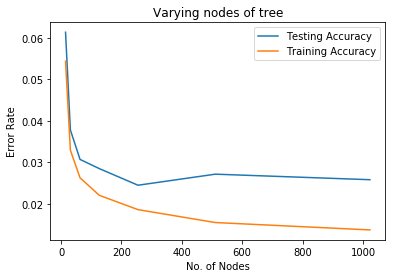

In [40]:
nodes = [15,31,63,127,255,511,1023]
test_error=Test_error1
train_error=Train_error1
plt.title('Varying nodes of tree')
plt.plot(nodes, test_error, label = 'Testing Accuracy')
plt.plot(nodes, train_error, label = 'Training Accuracy')
plt.legend()
plt.xlabel('No. of Nodes')
plt.ylabel('Error Rate')
plt.show()